# Check Algorithm Profits

In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    return series.rolling(window = window_len,min_periods = 1,center = False).mean()

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    return series.rolling(window = window_len,min_periods = 1,center = False).sum()

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [73]:
matches = pd.read_csv("databases/my_matches_db.csv", index_col = [0], skipinitialspace = True)
matches.head()

,season,stage,home_team_name,away_team_name,score,stadium_capcity,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,2008/2009,1,Manchester United,Newcastle United,1 - 1,75811.0,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,60361.0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,2008/2009,1,Sunderland,Liverpool,0 - 1,48707.0,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,35303.0,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,2008/2009,1,Aston Villa,Manchester City,4 - 2,42785.0,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


In [74]:
my_predictions = pd.read_csv("databases/my_predictions.csv", index_col = [0], skipinitialspace = True)
my_predictions.head()

,MYD,MYH,MYA
1177,0.175000,0.618333,0.206667
394,0.280000,0.641667,0.078333
1722,0.208333,0.673333,0.118333
1913,0.356667,0.215000,0.428333
1428,0.426667,0.220000,0.353333


### Betting odds features

In [75]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = b365_features

In [76]:
matches[my_features] = my_predictions

In [77]:
new_matches = matches.dropna(axis = 0)

###  Features with nan values

In [78]:
max_bet_per_match = 500

In [79]:
matches_betting_odds_features = new_matches[current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features = trasform_ratios_to_probs(matches_betting_odds_features)
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])


matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,B365D,B365H,B365A,predictions,real_score,right_wrong,bet_ratio
334,0.287770,0.474820,0.237410,1,1,1,2.05
335,0.286689,0.450512,0.262799,1,1,1,2.10
339,0.305792,0.430888,0.263320,1,0,0,2.20
341,0.157407,0.787037,0.055556,1,2,0,1.20
342,0.252178,0.602335,0.145487,1,1,1,1.62


In [80]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [81]:
new_matches_betting_odds_features.head()

,B365D,B365H,B365A,right_wrong,bet_ratio
334,0.287770,0.474820,0.237410,1,2.05
335,0.286689,0.450512,0.262799,1,2.10
339,0.305792,0.430888,0.263320,0,2.20
341,0.157407,0.787037,0.055556,0,1.20
342,0.252178,0.602335,0.145487,1,1.62


In [82]:
calc_rolling_mean(new_matches_betting_odds_features,"right_wrong").tail()

2968    0.541513
2971    0.541014
2973    0.541436
2977    0.540938
2978    0.540441
Name: right_wrong, dtype: float64

In [83]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features["right_wrong"]

### Spliting the data 

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(new_features, new_lables, test_size = 0.30, random_state = 101)

In [86]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [87]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = 101)

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [91]:
chosen_model = rfc
predictions  = chosen_model.predict(X_test_inner)

In [92]:
from sklearn.metrics import classification_report,confusion_matrix

In [93]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.47      0.41      0.44       112
          1       0.50      0.56      0.53       117

avg / total       0.49      0.49      0.49       229



**confusion_matrix:**

[[46 66]
 [51 66]]


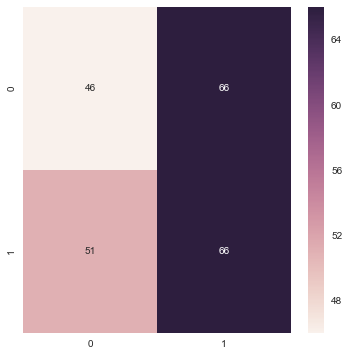

In [94]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [95]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
B365D,-1.911252
B365H,1.641403
B365A,0.184409


In [96]:
def get_optimal_bet(df,model,max_bet):
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1] * max_bet,index = df.index)

In [97]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
X_test_outer["right_wrong"] = y_test_outer

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
X_test_outer.head()

,B365D,B365H,B365A,bet_ratio,bet,right_wrong
2962,0.277412,0.473629,0.248959,2.10,199.058820,1
858,0.291658,0.296216,0.412126,2.38,135.865079,1
1486,0.291658,0.412126,0.296216,2.40,0.000000,0
41,0.235955,0.629213,0.134831,1.53,0.000000,0
861,0.295826,0.359940,0.344234,2.63,388.102513,1


In [100]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [101]:
calc_rolling_mean(games_worth_betting,"right_wrong").tail()

2682    0.639053
428     0.641176
952     0.637427
1655    0.633721
2899    0.635838
Name: right_wrong, dtype: float64

In [102]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [103]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2008/2009,11,Stoke City,Arsenal,2 - 1,2,0,1.40,407.277778,-407.277778,-407.277778,407.277778
1,2008/2009,13,Manchester United,Stoke City,5 - 0,1,1,1.14,371.666667,52.033333,-355.244444,778.944444
2,2008/2009,13,Everton,Middlesbrough,1 - 1,1,0,1.90,143.312724,-143.312724,-498.557168,922.257168
3,2008/2009,13,West Bromwich Albion,Chelsea,0 - 3,2,1,1.30,155.000000,46.500000,-452.057168,1077.257168
4,2008/2009,15,Aston Villa,Fulham,0 - 0,1,0,1.60,54.302249,-54.302249,-506.359417,1131.559417


In [104]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 264.0247585619047 $
Max  Bet             = 500.0 $
Min  Bet             = 4.66071428571 $ 

Mean Profit          = 24.559387611366407 $
Max  Profit          = 632.607096561 $
Min  Profit          = -500.0 $ 

Total Money Invested = 45676.28323120951 $
Profits              = 4248.774056766389 $
Profit Percentage    = 9.301925980403114 %


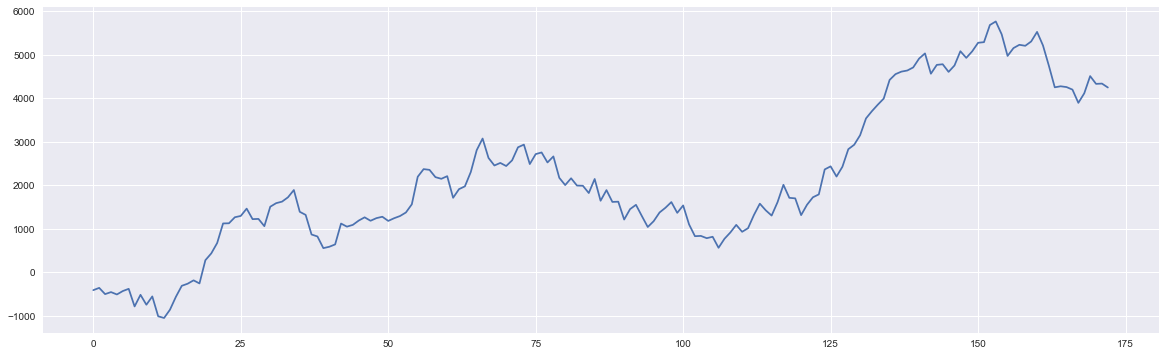

In [105]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])